In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib  as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
from argparse import Namespace as NS
from os.path import join
import yaml
import torch
import torch.nn as nn
from syngan.models import OjaNet, OjaRule, LocalMLP, ModuleWrapper
from syngan.post_hoc_analysis import (load_network_from_checkpoint as load,
                                      generate_quiver, rule_wrapper,
                                      plot_2Dheatmap)

from scipy.optimize import root


## Load data and fits

In [3]:
## ----------------------------------- Data -----------------------------------------
# Path to data
path_to_data_3 = join("..", "..", "data", "oja_net_small")
path_to_data_noise = join("..", "..", "data", "oja_net_noise_small")
path_to_data_39 = join("..", "..", "data", "oja_net_big")

# Load config
with open(join(path_to_data_3, "config.yaml"), "r") as f:
    sconf = NS(**yaml.full_load(f))

# Load test data for 3 pre-syn neur; no noise
test_data_3 = np.load(join(path_to_data_3, "extra_test_data.npz"))
X3, Y3, PCs3, weights3, scores3 = test_data_3["presyn_act"], test_data_3["postsyn_act"],\
test_data_3["presyn_pcs"], test_data_3["weights"], test_data_3["scores"]

# Load test data for 3 pre-syn neur; with added noise
test_data_noise = np.load(join(path_to_data_noise, "test_data.npz"))
Xn, Yn, PCsn, weightsn, scoresn = test_data_noise["presyn_act"], test_data_noise["postsyn_act"],\
test_data_noise["presyn_pcs"], test_data_noise["weights"], test_data_noise["scores"]

# Load test data for 39 pre-syn neur; no noise
test_data_39 = np.load(join(path_to_data_39, "test_data.npz"))
X39, Y39, PCs39, weights39, scores39 = test_data_39["presyn_act"], test_data_39["postsyn_act"],\
test_data_39["presyn_pcs"], test_data_39["weights"], test_data_39["scores"]

# Make GT net
gt_net = OjaNet(OjaRule(sconf.n_presyn_neur, sconf.n_postsyn_neur),
                sconf.update_rate,
                sconf.n_presyn_neur,
                sconf.n_postsyn_neur,
                sconf.timesteps,
                noise_amplitude=0.)


In [5]:
## ----------------------------------- Load fits -------------------------------------------
prefix = ".."
prefix = ".."

path_to_fits = {"small-gan": prefix + "oja_net_small/<>",
                "noise_small-gan": prefix + "oja_net_noise_small/<>",
                "big-gan": prefix + "oja_net_big/<>",
               }

generators = {k: load(path,
                      "oja_net_small",
                      path_to_sim_conf="../../data/oja_net_%s/" % k.split("-")[0],
                      path_to_fit_conf="../tasks/oja_net_%s/" % k.split("-")[0])
             for k, path in path_to_fits.items()
             }


# Copy Local MLP parameters from 39 presyn fit to Local MLP with 3 presyn inputs
temp1 = generators["big-gan"]
rule1 = LocalMLP([nn.Linear(3, 100, bias=False),
                  nn.Sigmoid(),
                  nn.Linear(100, 100, bias=False),
                  nn.Sigmoid(),
                  nn.Linear(100, 1, bias=False),
                  ModuleWrapper(torch.reshape,
                                shape=(-1,
                                       3, 1))],
                3, 1)

for p1, pp1 in zip(rule1.parameter.parameters(),
                   temp1.update_rule.parameter.parameters(),
                   ):
    p1.data = pp1.data

generators["big-gan"]= OjaNet(rule1)
generators["gt"] = gt_net


In [7]:
def get_roots():
    x = 0.5

    roots = {
         "noise_small-gan": {"y": [0.25],
                         "init_w": [0.75],
                         "w": []},
         "big-gan": {"y": [-.75, 0., .75],
                "w": [],
                "init_w": [-1., 0., 1.]},

        }
    for key in ["noise_small-gan", "big-gan"]:
        for yy, rand in zip(roots[key]["y"], roots[key]["init_w"]):
            rootfinder = root(rule_wrapper(generators[key].update_rule), rand, args=(x, yy),
                              method='hybr')#, jac=jac_rule(loc_mlp))
            roots[key]["w"].append(rootfinder.x)
    return roots


## Make figure

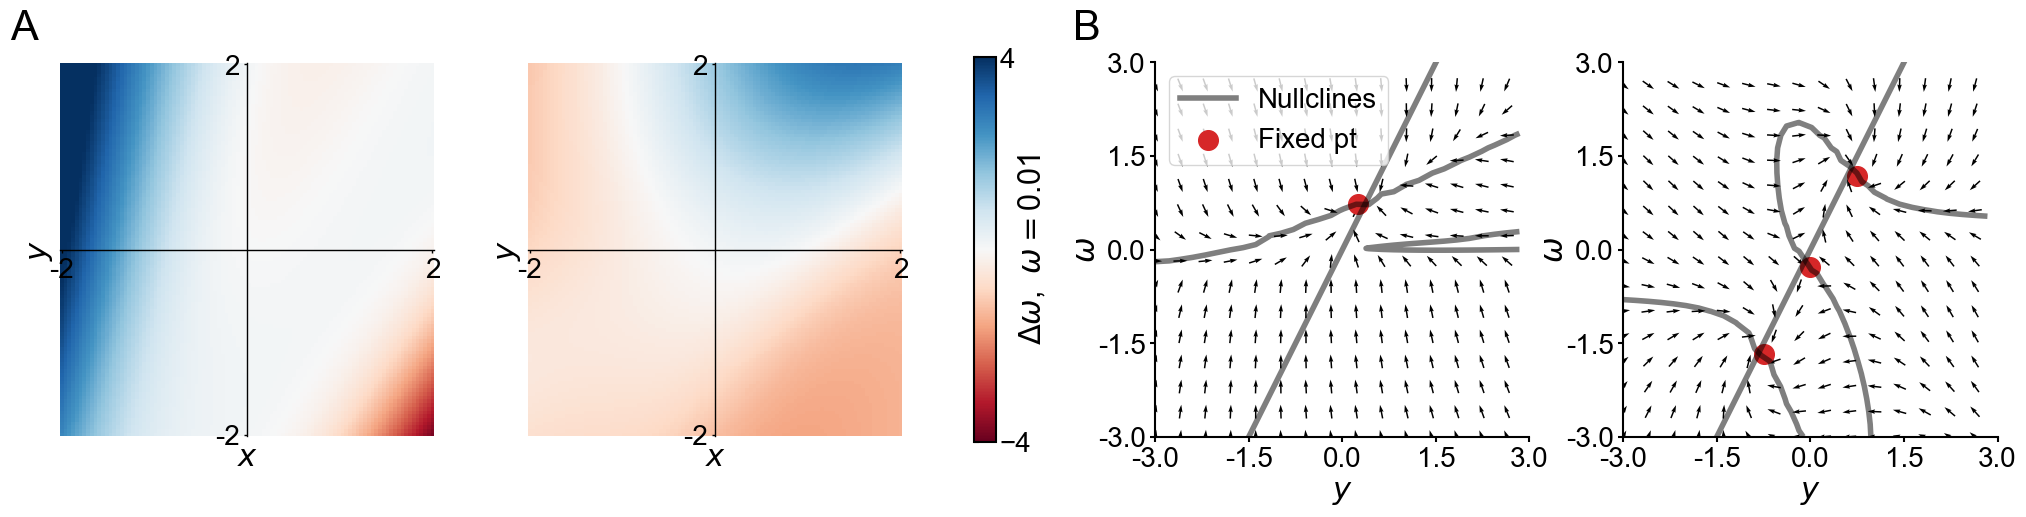

In [41]:
with mpl.rc_context(fname="./matplotlibrc"):
    fig = plt.figure(figsize=(25, 5.))
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=.3)
    fig.tight_layout()

    gs = plt.GridSpec(1, 5, width_ratios=(2., 2., .35, 2., 2.))

    # Panel heatmaps
    for i, (key, colax) in enumerate(zip(["noise_small-gan", "big-gan"], [None, cax])):
        ax = plt.subplot(gs[i])
        c = plot_2Dheatmap(rule_wrapper(generators[key].update_rule),
                       ax,
                       0.01,
                       cax=None,
                       x_range = [-2,2],
                       y_range = [-2,2],
                       n_points = [100,100],
                       fontsize=20,
                       labelpad=115,
                       labelsize=22)
#         if colax is not None:
    cax = plt.subplot(gs[2])
    cax.axis('off')
    c_divider = make_axes_locatable(cax)
    cax_div = c_divider.append_axes("left", size="100%", pad=1.1)
    cbar = plt.colorbar(c, cax=cax_div, ticks=[-4, 4])#, orientation="horizontal")
    cbar.ax.tick_params(labelsize=20, pad=15)
    cbar.set_label(r'$\Delta \omega$,'+ "  " +r'$\omega = $0.01',
                   size=22, labelpad = -10)


    # Panel phase portraits
    x = 0.5
    for i, (key, lim) in enumerate(zip(["noise_small-gan", "big-gan"], [[-3, 3], [-3, 3]])):
        ax = plt.subplot(gs[i + 3])
        roots = get_roots()
        w_range = np.linspace(lim[0], lim[1], 150)
        y_range = np.linspace(lim[0], lim[1], 150)

        Y, W, DY, DW = generate_quiver(rule_wrapper(generators[key].update_rule),
                                       w_range=w_range, y_range=y_range)
        ax.quiver(Y[::2, ::2], W[::2, ::2], DY[::2, ::2], DW[::2, ::2], pivot='mid')
        ax.set_xlim(lim[0], lim[1])
        ax.set_ylim(lim[0], lim[1])
        ax.set_aspect(1)
        ax.set_xticks(np.linspace(lim[0], lim[1], 5))
        ax.set_xticklabels(np.linspace(lim[0], lim[1], 5))
        ax.set_yticks(np.linspace(lim[0], lim[1], 5))
        ax.set_yticklabels(np.linspace(lim[0], lim[1], 5))
        ax.set_xlabel(r"$y$", fontsize=22)
        ax.set_ylabel(r"$\omega$", fontsize=22, labelpad=-2.5)


        y_fp, w_fp = roots[key]["y"], roots[key]["w"]
        ax.contour(Y, W, DW, [0], colors="k", alpha=.5, linewidths=[4])
        ax.plot(w_range * x, w_range, lw=4, color="k", alpha=.5, label="Nullclines")
        ax.scatter(y_fp, w_fp, s=200, color="tab:red", label="Fixed pt")

        if i==0.:
            ax.legend(frameon=True, fontsize=20)#, bbox_to_anchor=(.35, .7, .2, .2))

    fig.text(0.105, .915, "A", fontsize=30)
    fig.text(0.53, .915, "B", fontsize=30)

    fig.savefig("supp_fig_3.jpg")
